In [1]:
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx

import requests


# Urban geospatial connectivity
This workshop takes an interested citizen through a series of analyses based on geospatial networks. The analyses are intended to showcase how open data and network algorithms can be used to understand the structure of urban environments and infer whether they work for us, the citizens. 

## Understanding the city with networks
- Basic routing on a network
    - How did you get to the conference?
- From a single route to many routes
    - Accessibility analysis with Pandana
- How walkable is Wellington?
    - Using playgrounds as a proxy for local walkability
    - Using street gradients to change walking times / distances
    - Using spatial filters to look at walkability by suburb
- Catchment areas of an amenity
    - Converting accessibility to isochrones
- What are the most connected suburbs?
    - Using network metrics to define connectivity
    - Best connected areas for walking
    - Well connected regions of public transit

# Data Science Foundations

## Data structures and definitions
The groundwork for the analyses requires a minimal understanding of:

| Components | Topics |
|:----------:|:------:|
|data definitions | attribute table |
| | spatial primitives| 
| | networks (graphs)|
|data structures | dataframes | 
| | spatial dataframes|
| | graph dataframes| 


In [2]:
wcc_playgrounds = gpd.read_file('zip://../data/WCC_Playgrounds.zip')
wcc_playgrounds.head()

,OBJECTID,location,suburb,playground,Housing,geometry
0,1,Salamanca Road,Kelburn,Kelburn Park Play Area,No,POINT (174.76973 -41.28487)
1,2,Farnham Street,Mornington,Farnham Street Play Area,No,POINT (174.76947 -41.31994)
2,3,Harrison Street,Brooklyn,Harrison Play Area,No,POINT (174.76482 -41.30601)
3,4,Jeypore Street,Berhampore,Jeypore Street Play Area,No,POINT (174.77340 -41.32199)
4,5,Brooklyn Road,Brooklyn,Central Park Play Area,No,POINT (174.76810 -41.29968)


## Attribute table
- row per entity with attributes in columns
- Table of WCC playgrounds
    - row per playground
    - attributes: suburb, location, playground name, housing

## Spatial primitives
- POINT
- LINE
- POLYGON
    

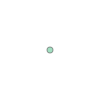

In [3]:
point = Point((0, 0))
point

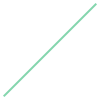

In [4]:
line = LineString([(0, 0), (1, 1)])
line

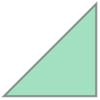

In [5]:
polygon = Polygon([(0, 0), (1, 1), (1, 0)])
polygon

## More complex spatial objects
- MultiPoint
- MultiLineString
- MultiPolygon    

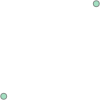

In [6]:
multipoints = MultiPoint([(0, 0), (1, 1)])
multipoints

## Networks
- Nodes
- Edges
    

/home/shrividya/anaconda2/envs/foss4g-workshop/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


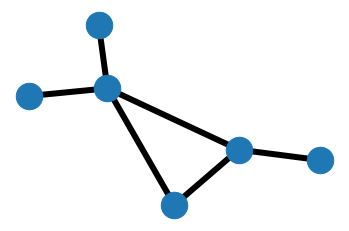

In [7]:
G = nx.Graph()

G.add_edge('a', 'b', weight=6)
G.add_edge('a', 'c', weight=2)
G.add_edge('c', 'd', weight=1)
G.add_edge('c', 'e', weight=7)
G.add_edge('c', 'f', weight=9)
G.add_edge('a', 'd', weight=3)

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos,  width=6)

plt.axis('off')
plt.show()

Both nodes and edges can have associated attributes. 
- Nodes
    - magnitude
    - class
- Edges
    - weights
    - class
    - direction

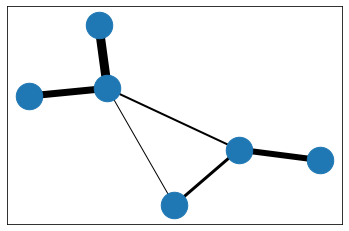

In [8]:
# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(G, pos, width=weights)

| Components | Topics |
|:----------:|:------:|
| data retrieval / load | csv, excel | 
| | Overpass API|
| |  osmnx| 
| data wrangling | attributes | 
| | spatial data
| | graph data | 
| data visualisation | matplotlib | 
| | seaborn | 
| | folium | 


## Data retrieval

### From file

In [9]:
# Read csv



In [10]:
# Read geospatial data
wcc_playgrounds = gpd.read_file('zip://../data/WCC_Playgrounds.zip')
wcc_playgrounds.head()

,OBJECTID,location,suburb,playground,Housing,geometry
0,1,Salamanca Road,Kelburn,Kelburn Park Play Area,No,POINT (174.76973 -41.28487)
1,2,Farnham Street,Mornington,Farnham Street Play Area,No,POINT (174.76947 -41.31994)
2,3,Harrison Street,Brooklyn,Harrison Play Area,No,POINT (174.76482 -41.30601)
3,4,Jeypore Street,Berhampore,Jeypore Street Play Area,No,POINT (174.77340 -41.32199)
4,5,Brooklyn Road,Brooklyn,Central Park Play Area,No,POINT (174.76810 -41.29968)


### Overpass API
Overpass is the read-only API for OpenStreetMap (OSM). 
> Overpass API allows you to query for OSM data by your own search criteria. For this purpose, it has two specifically crafted query languages: Overpass XML, and Overpass QL. 

For this workshop, we will only compose simple queries with Overpass QL. Since queries are strings, we can put them together programmatically using the expected structure. The query strings can be tested before running locally on: https://overpass-turbo.eu/

Query components:
- **Output format**: JSON, XML
- **Bounding box**: the area where we want the search performed. 
- **OSM data primitives**: ways, nodes, tags, relations.

The data primities of OSM have an intrinsic hierarchy with nodes being the root primitive. The primitives are split between spatial objects and object metadata.  

**Spatial objects**
- **Nodes**: Single point with explicit [lat, lon] coordinates.
- **Ways**: Collection of nodes that defines a polygon (e.g. a building) or polyline (e.g. a road). 

**Metadata**
- **Relations**: Represent the relationship of existing nodes and ways
- **Tags**: Metadata stored as key-value pairs. 

The main primitives we will used are nodes and tags. The nodes give the geolocation while we use the tags to filter specifically for the amenity of interest: fuel stations. 


**Resources** 
- More information about the entities of OpenStreetMap can be found [here](https://en.wikipedia.org/wiki/OpenStreetMap#Operation). 
- Full tutorial about the Overpass API language [here](https://wiki.openstreetmap.org/wiki/Overpass_API/Language_Guide)

#### Bounding Box
![](../assets/bounding-box-selection.png)

In [11]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.5813,-41.4552,175.0722,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

#### Construct Overpass query string to get fuel stations

In [12]:
# OSM data
tags = ['fuel'] # in list for loop
objects = ['node'] # in list for loop: any of way, node, relation
entity = "amenity" # Query currently only supports one type of entity at a time

# Generate Query string
compactOverpassQLstring = '[out:json][timeout:60];('
for tag in tags:
    for obj in objects:
        compactOverpassQLstring += '%s["%s"="%s"](%s,%s,%s,%s);' % (obj, entity, tag,
                                                                    osm_bbox[0],
                                                                    osm_bbox[1],
                                                                    osm_bbox[2],
                                                                    osm_bbox[3])
compactOverpassQLstring += ');out body;>;out skel qt;'    

# look at query
print(compactOverpassQLstring)

[out:json][timeout:60];(node["amenity"="fuel"](-41.4552,174.5813,-41.1527,175.0722););out body;>;out skel qt;


#### Test query
![](../assets/overpass-result-fuel-stations.png)

#### Get query results and insert into dataframe

In [13]:
# Request data from Overpass
osmrequest = {'data': compactOverpassQLstring}
osmurl = 'http://overpass-api.de/api/interpreter'

# Ask the API
osm = requests.get(osmurl, params=osmrequest)

# Convert the results to JSON and get the requested data from the 'elements' key
# The other keys in osm.json() are metadata guff like 'generator', 'version' of API etc. 
osmdata = osm.json()
osmdata = osmdata['elements']

# Convert to dataframe
osm_df = pd.DataFrame(osmdata)
osm_df.head()

,type,id,lat,lon,tags
0,node,203840709,-41.175811,174.825616,{'amenity': 'fuel'}
1,node,206201048,-41.222137,174.807039,"{'amenity': 'fuel', 'brand': 'Mobil', 'name': ..."
2,node,206201049,-41.225857,174.807492,"{'amenity': 'fuel', 'brand': 'BP', 'fuel:diese..."
3,node,300202137,-41.306680,174.763337,"{'amenity': 'fuel', 'operator': 'Caltex'}"
4,node,307348809,-41.232089,174.837406,"{'amenity': 'fuel', 'brand': 'BP', 'fuel:HGV_d..."


Need to extract the nested JSON inside the 'tags' column before producing the results dataframe

In [14]:
# Convert JSON output to pandas dataframe
for dct in osmdata:
    if 'tags' in dct:
        for key, val in dct['tags'].items():
            dct[key] = val
        del dct['tags']
    else:
        pass
osm_df = pd.DataFrame(osmdata)

Due to the hodgepodge nature of associated metadata in OSM, we get a very wide dataframe. But, that's fine since we mainly care about the fuel station brand, name and location. 

In [15]:
osm_df.head()

,type,id,lat,lon,amenity,brand,name,fuel:diesel,fuel:lpg,fuel:octane_91,...,wheelchair,diesel,addr:housenumber,addr:postcode,addr:street,opening_hours,addr:suburb,amenity_1,fuel:electric,ref:linz:address_id
0,node,203840709,-41.175811,174.825616,fuel,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,206201048,-41.222137,174.807039,fuel,Mobil,Mobil Johnsonville,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,206201049,-41.225857,174.807492,fuel,BP,BP Johnsonville,yes,yes,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,300202137,-41.306680,174.763337,fuel,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,307348809,-41.232089,174.837406,fuel,BP,BP Hutt Road,yes,NaN,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exercise
- Put Overpass API query construction in function
- Use function to get an amenity in an area of your choice

### Osmnx

In [16]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

